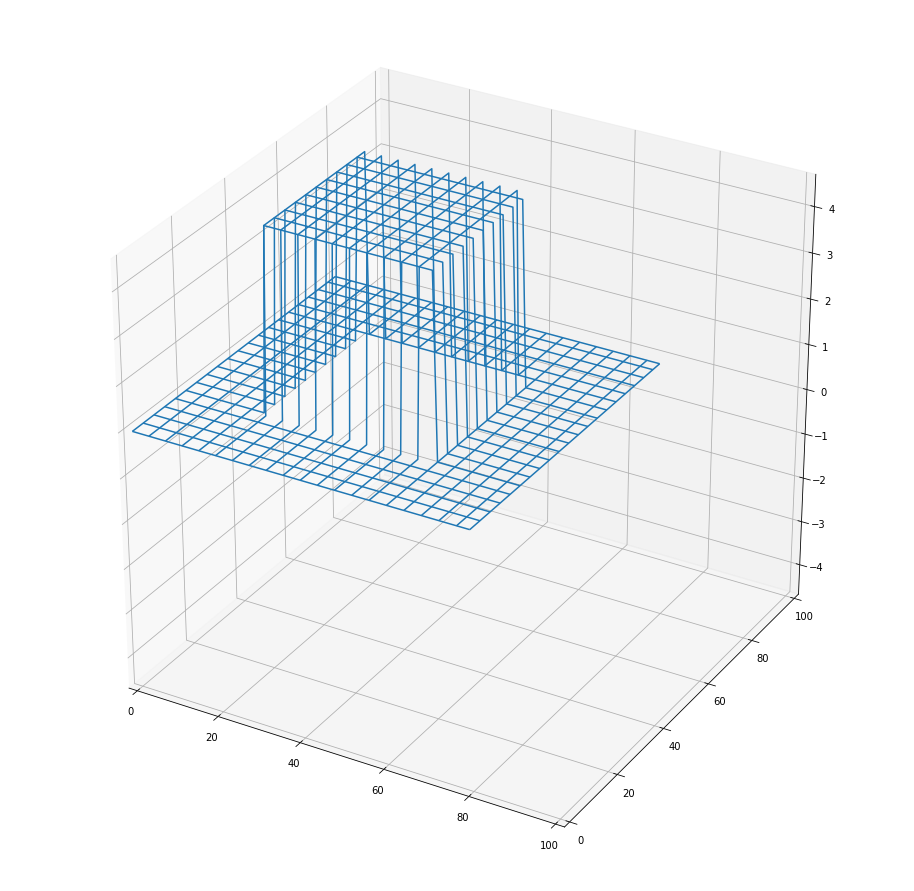

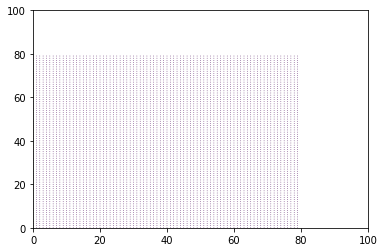

In [235]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from ipywidgets import interactive, Button
from IPython.display import display


X, Y = 0, 1
sizex = 80
sizey = 80
dt = 1
time = 0
# porportions
k = 0.001
#initial conditions
H = np.ones((sizex, sizey))
H[20:60, 20:60] = 5
U = np.zeros((sizex, sizey))
V = np.zeros((sizex, sizey))



# init()


def partial(a, ax):
    partial = np.roll(a, -1, ax) - np.roll(a, 0, ax) # f(x+dx) - f(x) / dx
    return (partial)
def d_dx(a):
    d_dx = partial(a, 0)
    d_dx[0] = np.zeros(d_dx[0].shape) # first row is roll-over nonsense
    return d_dx
def d_dy(a):
    d_dy = partial(a, 1)
    d_dy[:,0] = np.zeros(d_dy[:,0].shape) # first collumn is roll-over nonsense
    return d_dy
def divergence(u, v):
    div = (np.roll(d_dx(u), 1, 0)+np.roll(d_dy(v), 1, 1))
    return div

def timestep(ui, vi, hi, dt):
    u = ui
    v = vi
    h = hi
    u += -k*d_dx(h)*dt # du/dt = -k*dh/dx
    v += -k*d_dy(h)*dt # dv/dt = -k*dh/dy
    h += -divergence(u, v)*dt # dh/dt = -div([u,v])
    return u, v, h

def dispimg(a):
    imgplot = plt.imshow(a, 'Oranges')
    plt.colorbar()
    # plt.savefig('h')

def disp3d(a, xlim, ylim, rstr = 10, cstr = 10):
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(len(a))
    xx, yy = np.meshgrid(x, y)
    # Plot wireframe.
    ax.plot_wireframe(xx, yy, a, rstride=rstr, cstride=cstr)
    
    ax = plt.gca()
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(-4.5, 4.5)
    
    plt.show()

def vect(u, v, xlim, ylim, arsize = 1):
    fig, ax = plt.subplots()
#     xx, yy = np.meshgrid(np.arange(u.shape[0]), np.arange(u.shape[1]))
    m = np.hypot(u, v)
    ax.quiver(u, v, m, scale = 1/arsize)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.show()
    

    

disp3d(H, [0, 100], [0, 100], 4, 4)
vect(U, V, [0, 100], [0, 100])

In [236]:

def planegauss(shape, w = 1/2, h = 1): # function to generate a gaussian across a 3d array
    npx = np.linspace( -2, 2, shape[0] )
    npy = np.linspace( -2, 2, shape[1] ) # gaussian phase shift
    npxx, npyy = np.meshgrid(npx, npy)
    h = h*np.exp( -np.e * ( npxx**2 + npyy**2 ) / (w*w) )
    return (h)

# displays resulting water height after time t
def simulate(t, dt = 1):
    #initial conditions
    u = np.zeros((100, 100))
    v = np.zeros((100, 100))
    h = np.ones((100, 100))
    h[20:40, 40] = 6*np.exp( -(np.linspace(-2, 2, 20))**2 )#planegauss((20, 1), 1, 5) + 1 # a peak in the water
#     u[20:40, 20:40] = 0.1 #planegauss((20, 20), 1, 0.166) # that is moving with velocity porpotional to its hieght
    
    if (dt == 0):
        return False
    
    #iterate some number of times with interval size dt
    itr = 0
    while (itr < t):
        u, v, h = timestep(u, v, h, dt)
        itr += dt
    
    # display resulting height
    print('integral dxdy: ')
    print(np.sum(h))
    print('TOTAL divergence: ')
    print(np.sum(diverge(u, v)))
    disp3d(h, [0, 100], [0, 100], 5, 5)
    vect(u, v, [0, 100], [0, 100], 2)
    

# def simvals(t, dt):
#     gobutton = Button(description = 'simulate')
#     gobutton.on_click(print(t, dt))#simulate(t, dt))
#     display(gobutton)

controls = interactive(simulate, {'manual' : True, 'manual_name' : 'run simulation'},
                       t = (0, 1000, 1), # time elapsed
                       dt = (0.1, 10, 0.01)
                       ) # time interval


display(controls)

interactive(children=(IntSlider(value=500, description='t', max=1000), FloatSlider(value=1.0, description='dt'…

In [177]:
def f(b): print('clicked!')
button = Button(description = 'clickme')
button.on_click(f)
display(button)

Button(description='clickme', style=ButtonStyle())

clicked!
clicked!
clicked!
